# Classifying dogs vs cats with Alex Net
In this notebook, we try to implement a (somehow simplified) version of Alex Net to solve the Cats vs Dogs problem from Kaggle.

Following indications from course.fast.ai, the first step is clearly to download the dataset from Kaggle, after accepting the terms of use:

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

After downloading the test.zip and train.zip files, one should create a subfolder called 'data' in this notebook, and unzip the two folders in there. The resulting setup is something like
```
dogs_vs_cats_with_AlexNet.ipynb
data/
    train/
        cat.437.jpg
        dog.9924.jpg
        cat.1029.jpg
        dog.4374.jpg
    test/
        231.jpg
        325.jpg
        1235.jpg
        9923.jpg
```

During the first step, we will pre-process the files by splitting train and validation and also moving them into subfolders to be Keras-friendly (one "cats" and one "dogs" subfolder each)

In [1]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import os, errno
import numpy as np
from tqdm import tqdm
from shutil import copy
import numpy as np
import pandas as pd
import cv2

In [2]:
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

### Preprocess
OpenCV Histogram Equalization. This was how it was originally done in AlexNet. We could implement this as a layer in Keras, but for simplicity and consistency with https://github.com/adilmoujahid/deeplearning-cats-dogs-tutorial we'll do it beforehand

In [3]:
def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img

In [4]:
def create_dir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [5]:
train_path = 'input/train'
valid_path = 'input/valid'
test_path = 'input/test'

In [6]:
train_raw_path = 'data/train/'
test_raw_path = 'data/test/'
valid_raw_path = 'data/valid'
create_dir(valid_raw_path)

First of all, for each between cats and dogs, move 1000 (out of 12500) images from train to validation.

In [7]:
cat_names = [c for c in os.listdir(train_raw_path) if c.startswith('cat')]
dog_names = [c for c in os.listdir(train_raw_path) if c.startswith('dog')]
for c in np.random.choice(cat_names, 1000, replace=False):
    os.rename(os.path.join(train_raw_path, c), os.path.join(valid_raw_path, c))
for d in np.random.choice(dog_names, 1000, replace=False):
    os.rename(os.path.join(train_raw_path, d), os.path.join(valid_raw_path, d))

In [8]:
len(os.listdir(train_raw_path)), len(os.listdir(valid_raw_path))

(21000, 4000)

In [9]:
# Function that applies transform_img to every element in input_folder, recursively,
# and saves the result in output_folder.

def transform_folder(input_folder, output_folder):
    create_dir(os.path.join(output_folder, 'cats'))
    create_dir(os.path.join(output_folder, 'dogs'))
    
    files = [(os.path.join(path, name), name) for path, subdirs, files in os.walk(input_folder) for name in files]
    
    for t, n in tqdm(files):
        img = cv2.imread(t, cv2.IMREAD_COLOR)
        img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
        if 'cat' in n:
            cv2.imwrite(os.path.join(output_folder, 'cats', n), img)
        elif 'dog' in n:
            cv2.imwrite(os.path.join(output_folder, 'dogs', n), img)
        else:
            cv2.imwrite(os.path.join(output_folder, n), img)

In [10]:
transform_folder(valid_raw_path, valid_path)

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:31<00:00, 125.85it/s]


In [11]:
transform_folder(train_raw_path, train_path)

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [02:47<00:00, 125.32it/s]


In [12]:
transform_folder(test_raw_path, test_path)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:40<00:00, 124.95it/s]


### Compute mean of all image
Because we'll want to center them

In [13]:
from scipy import misc

In [14]:
img_mean = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3))

train_files = [os.path.join(path, name) for path, subdirs, files in os.walk(train_path) for name in files]

for t in tqdm(train_files):
    img_mean += misc.imread(t) / len(train_files)

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:52<00:00, 399.64it/s]


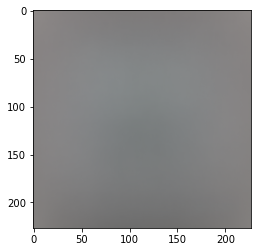

In [15]:
plt.imshow(img_mean.astype(np.int8))

It's pretty much uniform gray, with a slight lighter shade in the middle

# Start the keras stuff

In [16]:
import theano
import keras

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [17]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.layers.core import Layer
from keras.layers import merge
from keras.callbacks import CSVLogger

In [18]:
# Courtesy of https://github.com/heuritech/
# The only change (to adapt to newer versions of Keras / Theano) is to
# change the spatial_2d_padding arguments from "0, half" to
# "((0,0), (half,half))"
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """

    def f(X):
        b, ch, r, c = X.shape
        half = n // 2
        square = K.square(X)
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1))
                                              , ((0,0), (half,half)))
        extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:, i:i + ch, :, :]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

## The following is essentially Alex Net architecture
The only simplification (as code, the resulting network is denser) done is to use 5 "complete" convolutional layers instead of splitting two of them in half. The original choice was done to facilitate learning on 2 GPUs in parallel, but since we're using one GPU anyway...

The transpose in center is done to pass from usual (channels_last) to theano (channels_first) images.

In [19]:
def center(img):
    return img - img_mean.astype(np.float32).transpose([2,0,1])

alexnet = Sequential([
    Lambda(center, input_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH), output_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH)),
    Conv2D(96, 11, strides=(4,4), activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    crosschannelnormalization(),
    ZeroPadding2D((2,2)),
    Conv2D(256, 5, activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    crosschannelnormalization(),
    ZeroPadding2D((1,1)),
    Conv2D(384, 3, activation='relu'),
    ZeroPadding2D((1,1)),
    Conv2D(384, 3, activation='relu'),
    ZeroPadding2D((1,1)),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

Helper functions to get batches and fit models. They are both mutuated from course.fast.ai

In [20]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [21]:
def fit_model(model, batches, val_batches, nb_epoch=1, verbose=1, callbacks=None):
    model.fit_generator(batches, batches.n//batches.batch_size, epochs=nb_epoch, callbacks=callbacks,
                        validation_data=val_batches, validation_steps=val_batches.n//val_batches.batch_size, verbose=verbose)

Load batches for both training and validation.
batch_size=64 was chosen due to my small GPU with 2GB of vRAM. It should be proportionally (or even more, it's not optimized) increased for GPUs with more vRAM.

In [22]:
batches = get_batches(train_path, batch_size=64)
val_batches = get_batches(valid_path, batch_size=64, shuffle=True)

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [23]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alexnet.compile(optimizer=sgd,
               loss='categorical_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('training.log')

In [ ]:
# valid_batches and batches are wrongly named - inverted...
fit_model(alexnet, val_batches, batches, nb_epoch=20, callbacks=[csv_logger], verbose=0)

In [24]:
# Make a backup copy to avoid overwriting
copy('training.log', 'training_first_part.log')

In [ ]:
csv_logger = CSVLogger('training2.log')
# valid_batches and batches are wrongly named - inverted...
fit_model(alexnet, val_batches, batches, nb_epoch=50, callbacks=[csv_logger], verbose=0)

In [25]:
# Make a backup copy to avoid overwriting
copy('training2.log', 'training_second_part.log')

## Analyze how much we learnt

In [29]:
training_results = pd.concat((
    pd.read_csv('training_first_part.log'), pd.read_csv('training_second_part.log')
)).reset_index(drop=True)

In [27]:
print(training_results.shape)
training_results.head()

(70, 5)


,epoch,acc,loss,val_acc,val_loss
0,0,0.499302,8.070292,0.505165,7.975793
1,1,0.498692,8.080130,0.501550,8.034071
2,2,0.505276,7.974016,0.505165,7.975793
3,3,0.498343,8.085752,0.500000,8.059048
4,4,0.496294,8.118781,0.499483,8.067373


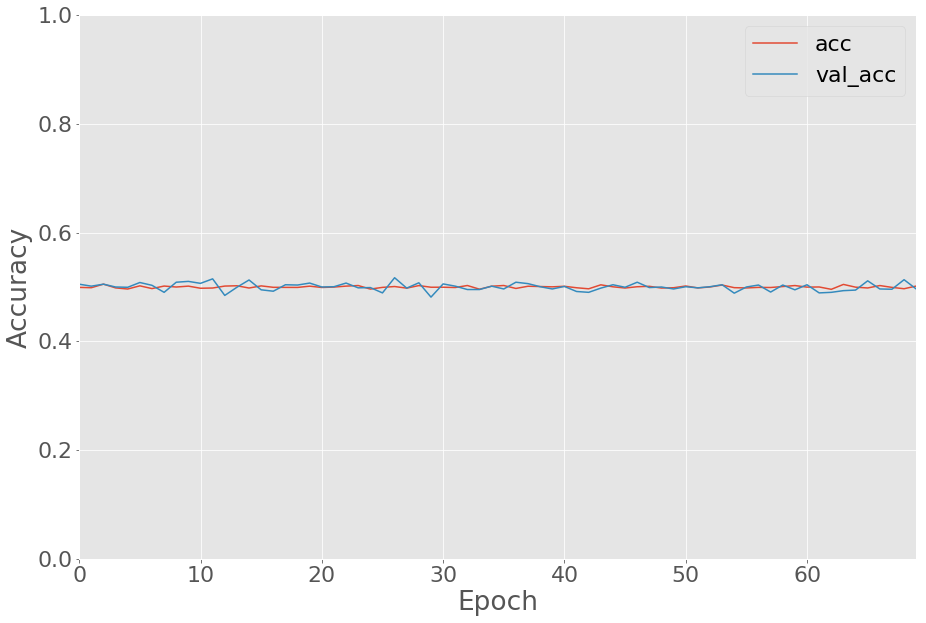

In [32]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

training_results[['acc', 'val_acc']].plot(figsize=(15,10))
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Bummer.